# Setup

In [1]:
pip install -q -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, initializers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Mean
from google.colab import drive
import numpy as np
import os
from tqdm.autonotebook import tqdm
from IPython.display import Image
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import shutil
from functools import partial

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  # Remove the CWD from sys.path while we load stuff.


In [3]:
%cd /content/
drive.mount("/content/drive")

/content
Mounted at /content/drive


In [4]:
!git clone https://github.com/yxczt/thesis.git

Cloning into 'thesis'...
remote: Enumerating objects: 38172, done.
remote: Counting objects: 100% (5170/5170), done.
remote: Compressing objects: 100% (5166/5166), done.
remote: Total 38172 (delta 3), reused 5170 (delta 3), pack-reused 33002
Receiving objects: 100% (38172/38172), 755.44 MiB | 40.10 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Checking out files: 100% (33342/33342), done.


In [5]:
%cd /content/thesis/
!ls -a

/content/thesis
.  ..  data  .git  README.md


In [6]:
def pbar(total_images, batch_size, epoch, epochs):
    bar = tqdm(total=(total_images // batch_size) * batch_size,
               ncols=int(get_terminal_width() * .9),
               desc=tqdm.write(f'Epoch {epoch + 1}/{epochs}'),
               postfix={
                   'g_loss': f'{0:6.3f}',
                   'd_loss': f'{0:6.3f}',
                   1: 1
               },
               bar_format='{n_fmt}/{total_fmt} |{bar}| {rate_fmt}  '
               'ETA: {remaining}  Elapsed Time: {elapsed}  '
               'G Loss: {postfix[g_loss]}  D Loss: {postfix['
               'd_loss]}',
               unit=' images',
               miniters=10)
    return bar

In [7]:
def save_image_grid(img_grid, epoch):
    file_name = 'Final_Faces' + f'_{epoch}.png'
    output_dir = os.path.join("/content/drive/MyDrive/thesis_results/faces_all/training/", file_name)
    tf.io.write_file(output_dir, tf.image.encode_png(tf.cast(img_grid, tf.uint8)))

In [8]:
def img_merge(images, n_rows=None, n_cols=None, padding=0, pad_value=0):
    images = (tf.cast(images, tf.float32) + 1.0) * 127.5
    images = np.array(images)
    n = images.shape[0]

    if n_rows:
        n_rows = max(min(n_rows, n), 1)
        n_cols = int(n - 0.5) // n_rows + 1
    elif n_cols:
        n_cols = max(min(n_cols, n), 1)
        n_rows = int(n - 0.5) // n_cols + 1
    else:
        n_rows = int(n**0.5)
        n_cols = int(n - 0.5) // n_rows + 1

    h, w = images.shape[1], images.shape[2]
    shape = (h * n_rows + padding * (n_rows - 1), w * n_cols + padding * (n_cols - 1))
    if images.ndim == 4:
        shape += (images.shape[3], )
    img = np.full(shape, pad_value, dtype=images.dtype)

    for idx, image in enumerate(images):
        i = idx % n_cols
        j = idx // n_cols
        img[j * (h + padding):j * (h + padding) + h, i * (w + padding):i *
            (w + padding) + w, ...] = image
    return img

In [9]:
def get_terminal_width():
    width = shutil.get_terminal_size(fallback=(200, 24))[0]
    if width == 0:
        width = 120
    return width

In [10]:
def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
  ):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x
    
def conv_block(
  x,
  filters,
  activation,
  kernel_size=(3, 3),
  strides=(1, 1),
  padding="same",
  use_bias=True,
  use_bn=False,
  use_dropout=False,
  drop_value=0.5,
):
  x = layers.Conv2D(
      filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
  )(x)
  if use_bn:
      x = layers.BatchNormalization()(x)
  x = activation(x)
  if use_dropout:
      x = layers.Dropout(drop_value)(x)
  return x

def down_new_block(n_filters, kernel_size, input_layer, strides = (1, 1)):
  init = initializers.RandomNormal(stddev=0.02)
  x = layers.Conv2D(n_filters, kernel_size, strides, padding='same', kernel_initializer=init)(input_layer)
  x = tfa.layers.InstanceNormalization(axis=-1)(x)
  x = layers.Activation('relu')(x)
  return x

def res_block(n_filters, input_layer):
  init = initializers.RandomNormal(stddev=0.02)
  x = down_new_block(n_filters, (3, 3), input_layer)
  x = layers.Conv2D(n_filters, (3, 3), padding='same', kernel_initializer=init)(x)
  x = tfa.layers.InstanceNormalization(axis = -1)(x)
  x = layers.Concatenate()([x, input_layer])
  return x

def up_new_block(n_filters, input_layer):
  init = initializers.RandomNormal(stddev=0.02)
  x = layers.Conv2DTranspose(n_filters, (3, 3), (2, 2), padding='same', kernel_initializer=init)(input_layer)
  x = tfa.layers.InstanceNormalization(axis=-1)(x)
  x = layers.Activation('relu')(x)
  return x

In [11]:
IMG_SHAPE = (128, 128, 3)
total_img_count = 2505
img_size = 128
epochs = 300
batch = 32
noise_dim = 1536

## Defining the Model

In [12]:
class WGANGP:
  def __init__(self, num_of_images = 2505, image_size = 128, epochs = 300, batch_size = 32, z_size = 1536, n_critic = 5, gp_weight = 10.0, loading = False):
    self.num_of_images = num_of_images
    self.image_size = image_size
    self.epochs = epochs
    self.batch_size = batch_size
    self.z_size = z_size
    self.n_critic = n_critic
    self.gp_weight = gp_weight
    if loading:
      %cd /content/drive/MyDrive/thesis_results/faces_all/
      self.Gen = tf.keras.models.load_model("generator_full.h5")
      self.Disc = tf.keras.models.load_model("discriminator_full.h5")
      self.gen_losses = np.loadtxt("genlosses.txt", delimiter=',')
      self.disc_losses = np.loadtxt("disclosses.txt", delimiter=',')
    else:
      self.Gen = self.build_generator()
      self.Disc = self.build_discriminator()
      self.gen_losses = np.array([])
      self.disc_losses = np.array([])
    self.gen_optimizer = Adam(0.00001)
    self.disc_optimizer = Adam(0.00001)

    self.Gen.summary()
    self.Disc.summary()

  def build_generator(self):
    %cd /content/drive/MyDrive/thesis_results/faces
    init = initializers.RandomNormal(stddev=0.02)
    gen_first = tf.keras.models.load_model("generator.h5")
    %cd /content/drive/MyDrive/thesis_results/natural_bg
    gen_second = tf.keras.models.load_model("generator.h5")
    %cd /content/drive/MyDrive/thesis_results/faces_all
    for i, layer in enumerate(gen_first.layers):
      layer.trainable = False
      layer._name = f"layer_{10000 + i}"
    for layer in gen_second.layers:
      layer.trainable = False
    x = layers.concatenate([gen_first.output, gen_second.output])
    x = layers.Conv2D(3, 1)(x)
    x = layers.Activation("relu")(x)
    x = down_new_block(64, (7, 7), x)
    x = down_new_block(128, (3, 3), x, (2, 2))
    x = down_new_block(256, (3, 3), x, (2, 2))
    for _ in range(6):
      x = res_block(256, x)
    x = up_new_block(128, x)
    x = up_new_block(64, x)
    x = layers.Conv2DTranspose(3, (7, 7), padding='same', kernel_initializer=init)(x)
    x = tfa.layers.InstanceNormalization(axis=-1)(x)
    output = layers.Activation('tanh')(x)
    g_model = Model([gen_first.input, gen_second.input], output, name = "generator")
    return g_model


  def build_discriminator(self):
    img_input = layers.Input(shape=IMG_SHAPE)
    x = conv_block(
        img_input,
        48,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        96,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        192,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        384,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
    )

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = Model(img_input, x, name="discriminator")
    return d_model

  def train(self, dataset):
    z1 = tf.random.normal((self.batch_size, 1, 1, self.z_size))
    z2 = tf.random.normal((self.batch_size, 1, 1, self.z_size))
    g_train_loss = Mean()
    d_train_loss = Mean()
    for epoch in range(self.epochs):
      bar = pbar(self.num_of_images, 32, epoch, self.epochs)
      for batch in dataset:
        for _ in range(self.n_critic):
          self.train_discrminator(batch)
          d_loss = self.train_discrminator(batch)
          d_train_loss(d_loss)

        g_loss = self.train_generator()
        g_train_loss(g_loss)
        self.train_generator()

        bar.postfix['g_loss'] = f'{g_train_loss.result():6.3f}'
        bar.postfix['d_loss'] = f'{d_train_loss.result():6.3f}'
        bar.update(self.batch_size)

      self.gen_losses = np.append(self.gen_losses, g_train_loss.result())
      self.disc_losses = np.append(self.disc_losses, d_train_loss.result())
      g_train_loss.reset_states()
      d_train_loss.reset_states()

      bar.close()
      del bar

      samples = self.Gen([z1, z2], training=False)
      image_grid = img_merge(samples, n_rows=8).squeeze()
      save_image_grid(image_grid, epoch + 1)
      if epoch % 5 == 0:
        self.saving_models()
  
  @tf.function
  def train_generator(self):
    z1 = tf.random.normal((self.batch_size, 1, 1, self.z_size))
    z2 = tf.random.normal((self.batch_size, 1, 1, self.z_size))
    with tf.GradientTape() as t:
      x_fake = self.Gen([z1, z2], training=True)
      fake_logits = self.Disc(x_fake, training=True)
      loss = -(tf.reduce_mean(fake_logits))
    grad = t.gradient(loss, self.Gen.trainable_variables)
    self.gen_optimizer.apply_gradients(zip(grad, self.Gen.trainable_variables))
    return loss
  
  @tf.function
  def train_discrminator(self, x_real):
    z1 = tf.random.normal((self.batch_size, 1, 1, self.z_size))
    z2 = tf.random.normal((self.batch_size, 1, 1, self.z_size))
    with tf.GradientTape() as t:
      x_fake = self.Gen([z1, z2], training=True)
      fake_logits = self.Disc(x_fake, training=True)
      real_logits = self.Disc(x_real, training=True)
      cost = tf.reduce_mean(fake_logits) - tf.reduce_mean(real_logits)
      gp = self.gradient_penalty(partial(self.Disc, training=True), x_real, x_fake)
      cost += self.gp_weight * gp
    grad = t.gradient(cost, self.Disc.trainable_variables)
    self.gen_optimizer.apply_gradients(zip(grad, self.Disc.trainable_variables))
    return cost

  def gradient_penalty(self, f, real, fake):
    alpha = tf.random.uniform([self.batch_size, 1, 1, 1], 0., 1.)
    diff = fake - real
    inter = real + (alpha * diff)
    with tf.GradientTape() as t:
        t.watch(inter)
        pred = f(inter)
    grad = t.gradient(pred, [inter])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(grad), axis=[1, 2, 3]))
    gp = tf.reduce_mean((slopes - 1.)**2)
    return gp
  
  def generate_samples(self):
    z1 = tf.random.normal((self.batch_size, 1, 1, self.z_size))
    z2 = tf.random.normal((self.batch_size, 1, 1, self.z_size))
    samples = self.Gen([z1, z2], training=False)
    image_grid = img_merge(samples, n_rows=8).squeeze()
    file_name = 'FinalFacesGeneratedRandom.png'
    output_dir = os.path.join("/content/drive/MyDrive/thesis_results/faces_all/generated_images/", file_name)
    tf.io.write_file(output_dir, tf.image.encode_png(tf.cast(image_grid, tf.uint8)))
  def saving_models(self):
    %cd /content/drive/MyDrive/thesis_results/faces_all
    self.Gen.save('generator_full.h5')
    self.Disc.save('discriminator_full.h5')
    np.savetxt('genlosses.txt', self.gen_losses, delimiter=',')
    np.savetxt('disclosses.txt', self.disc_losses, delimiter=',')



# Dataset preparation

In [13]:
def decode_img(file_path):
    file = tf.io.read_file(file_path)
    img = tf.image.decode_png(file, channels=3)
    img = (tf.dtypes.cast(img, tf.float32) / 127.5) - 1.0
    return img  

img_path = "/content/thesis/data/faces_final/faces_all/"
ds_train_paths = tf.data.Dataset.list_files(str(img_path + '*.png'))

ds_train = ds_train_paths.map(decode_img).cache().shuffle(2505).batch(32, drop_remainder=True)

In [14]:
unknown_image_batch = next(iter(ds_train))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


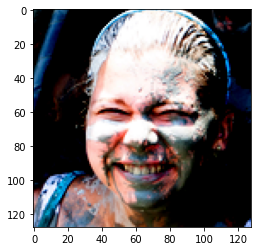

In [15]:
img = unknown_image_batch[5]
plt.imshow(tf.concat([img], 2))

# Training

In [16]:
%cd /content/drive/MyDrive/thesis_results/faces_all
wgan = WGANGP(loading=True)
%cd /content/drive/MyDrive/thesis_results/faces_all

/content/drive/MyDrive/thesis_results/faces_all
/content/drive/MyDrive/thesis_results/faces_all


Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 layer_10000 (InputLayer)       [(None, 1, 1, 1536)  0           []                               
                                ]                                                                 
                                                                                                  
 input_1 (InputLayer)           [(None, 1, 1, 1536)  0           []                               
                                ]                                                                 
                                                                                                  
 layer_10001 (Dense)            (None, 1, 1, 1536)   2359296     ['layer_10000[0][0]']            
                                                                                          

In [ ]:
wgan.train(ds_train)

Epoch 1/300


0/2496 |                                                                                                   | ?…

/content/drive/MyDrive/thesis_results/faces_all


Epoch 2/300


0/2496 |                                                                                                   | ?…

Epoch 3/300


0/2496 |                                                                                                   | ?…

Epoch 4/300


0/2496 |                                                                                                   | ?…

Epoch 5/300


0/2496 |                                                                                                   | ?…

Epoch 6/300


0/2496 |                                                                                                   | ?…

/content/drive/MyDrive/thesis_results/faces_all


Epoch 7/300


0/2496 |                                                                                                   | ?…

Epoch 8/300


0/2496 |                                                                                                   | ?…

Epoch 9/300


0/2496 |                                                                                                   | ?…

Epoch 10/300


0/2496 |                                                                                                   | ?…

Epoch 11/300


0/2496 |                                                                                                   | ?…

/content/drive/MyDrive/thesis_results/faces_all


Epoch 12/300


0/2496 |                                                                                                   | ?…

Epoch 13/300


0/2496 |                                                                                                   | ?…

Epoch 14/300


0/2496 |                                                                                                   | ?…

Epoch 15/300


0/2496 |                                                                                                   | ?…

Epoch 16/300


0/2496 |                                                                                                   | ?…

/content/drive/MyDrive/thesis_results/faces_all


Epoch 17/300


0/2496 |                                                                                                   | ?…

Epoch 18/300


0/2496 |                                                                                                   | ?…

Epoch 19/300


0/2496 |                                                                                                   | ?…

Epoch 20/300


0/2496 |                                                                                                   | ?…

Epoch 21/300


0/2496 |                                                                                                   | ?…

/content/drive/MyDrive/thesis_results/faces_all


Epoch 22/300


0/2496 |                                                                                                   | ?…

Epoch 23/300


0/2496 |                                                                                                   | ?…

Epoch 24/300


0/2496 |                                                                                                   | ?…

Epoch 25/300


0/2496 |                                                                                                   | ?…

Epoch 26/300


0/2496 |                                                                                                   | ?…

/content/drive/MyDrive/thesis_results/faces_all


Epoch 27/300


0/2496 |                                                                                                   | ?…

Epoch 28/300


0/2496 |                                                                                                   | ?…

Epoch 29/300


0/2496 |                                                                                                   | ?…

In [19]:
wgan.generate_samples()

In [ ]:
wgan.saving_models()

# Evaluation

In [18]:
inception_model = tf.keras.applications.InceptionV3(include_top=False, 
                              weights="imagenet", 
                              pooling='avg')

87924736/87910968 [==============================] - 1s 0us/step


In [19]:
import math
from tqdm.autonotebook import tqdm
import numpy as np
def compute_embeddings(dataloader, count, generated = False):
    image_embeddings = []

    for _ in tqdm(range(count)):
        images = next(iter(dataloader))
        if generated:
          z1 = tf.random.normal((batch, 1, 1, noise_dim))
          z2 = tf.random.normal((batch, 1, 1, noise_dim))
          images = wgan.Gen([z1, z2], training=False)
        embeddings = inception_model.predict(images)

        image_embeddings.extend(embeddings)

    return np.array(image_embeddings)

count = math.ceil(512/batch)

# compute embeddings for real images
real_image_embeddings = compute_embeddings(ds_train, count)

# compute embeddings for generated images
generated_image_embeddings = compute_embeddings(ds_train, count, generated = True)

real_image_embeddings.shape, generated_image_embeddings.shape

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

((512, 2048), (512, 2048))

In [20]:
import scipy
def calculate_fid(real_embeddings, generated_embeddings):
  # calculate mean and covariance statistics
  mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
  mu2, sigma2 = generated_embeddings.mean(axis=0), np.cov(generated_embeddings,  rowvar=False)
  # calculate sum squared difference between means
  ssdiff = np.sum((mu1 - mu2)**2.0)
  # calculate sqrt of product between cov
  covmean = scipy.linalg.sqrtm(sigma1.dot(sigma2))
  # check and correct imaginary numbers from sqrt
  if np.iscomplexobj(covmean):
    covmean = covmean.real
  # calculate score
  fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid

fid = calculate_fid(real_image_embeddings, generated_image_embeddings)
fid

1494.6489474583386

In [ ]:
# 1494.6489

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


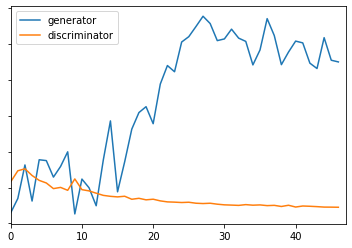

In [18]:
plt.plot(abs(wgan.gen_losses), label='generator')
plt.plot(abs(wgan.disc_losses), label='discriminator')
ax = plt.axes()
ax.set(xlim=(0, wgan.gen_losses.shape[0]))
ax.set_yticklabels([])
plt.legend()
plt.show()